# Main Notebook for Assignment 3

In [1]:
from itertools import chain
import matplotlib.pyplot as plt
import spacy
import pandas as pd
from spacy.tokens import Doc
from sklearn.metrics import confusion_matrix
import tqdm
import pandas as pd

# Load the SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Access the DependencyParser component
dependency_parser = nlp.get_pipe("parser")

GPU will significantly accelerate dependency parsing. **DO NOT RUN** the following block if there is no GPU/cuda support.

In [2]:
#import cupy
#spacy.require_gpu()

## Extract Features and Lables for each token in a sentence
The below block extract all ten features that are used for this CRF model and the BERT in the next assignment.

In [3]:
def extract_sentences_and_labels(df):
    """
    Gets a list of sentences, spaces per sentence, negation cues and a list of negation scopes. 
    Each sentence is a list of token dicts, spaces per sentence is a list of booleans,
    each negation cue is a list of indexes and each negation scope is a list of booleans.
    """
    sentences = []
    spaces = []
    neg_cues = []
    scope_sentences = []
    
    sentence = []
    sent_spaces = []
    neg_cue = []
    n = 0
    neg_scope = []
    for i, row in df.iterrows():
        token_dict = row.to_dict()
        # Check for the start of a new sentence (token_id == '0')
        if row['token_id'] == 0:
            n = 0
            sentences.append(sentence)
            sentence = [token_dict]

            spaces.append(sent_spaces)
            sent_spaces = [False if i == len(df)-1 else df['pos_tag'].iloc[i+1].isalpha()]

            scope_sentences.append(neg_scope)
            neg_scope = [str(row['negation_scope'] != '_')]
                
            neg_cues.append(neg_cue)
            neg_cue = []
        else:
            n += 1
            sentence.append(token_dict)
            neg_scope.append(str(row['negation_scope'] != '_'))
            sent_spaces.append(False if i == len(df)-1 else df['pos_tag'].iloc[i+1].isalpha())
            
        if row['negation_word'] != '_' and row['negation_word'] != '***':
            neg_cue.append(n)
            
    
    return sentences[1:], spaces[1:], neg_cues[1:], scope_sentences[1:]



def extract_sentence_features(sentence, spaces, neg_cue, parser):
    # Init features 
    features = []

    # Some of the common conjunction and punctuation. Case insensitive to use.
    conj_punt_set = [',','.','?','"','\'','!','``',':',';','\'\'','-','--','`','(',')','[',']',
                    'for','and','nor','but','or','yet','while','when','whereas','whenever','wherever','whether','if','because','before',
                     'until','unless','since','so','although','after','as','','Accordingly','After','Also','Besides','Consequently',
                     'Conversely','Finally','Furthermore','Hence','However','Indeed','Instead','Likewise','Meanwhile','Moreover','Nevertheless',
                     'Nonetheless','Otherwise','Similarly','Still','Subsequently','Then','Therefore','Thus','except','rather']

    # Get syntac tree
    tree = [t['parsing_tree'] for t in sentence]
    
    # Get dependency parser tree
    tokens = []
    for t in sentence:
        if type(t['token']) == str:
            tokens.append(t['token'])  
        else:
            tokens.append(' ')
    
    # Negation type
    if neg_cue:
        if len(neg_cue) > 1:
            neg_type = "MULTI"
        elif sentence[neg_cue[0]]['token'] != sentence[neg_cue[0]]['negation_word']:
            neg_type = "AFFIX"
        else: 
            neg_type = "NEG"
    else:
        neg_type = ""

    
    doc = Doc(nlp.vocab, words=tokens, spaces=spaces)
    parser(doc)
    cue_tokens = [token for i, token in enumerate(doc) if i in neg_cue]

    for i, token in enumerate(doc):
        feature_dict = {'token': sentence[i]['token'],     # Feature 1: Token 
                        'neg_type': neg_type,              # Feature 2: Negation type
                        'lemma': sentence[i]['lemma'],     # Feature 3: Lemma
                        'pos_tag': sentence[i]['pos_tag'], # Feature 4: POS tag
                        'is_neg': sentence[i]['negation_word'] != '_' and sentence[i]['negation_word'] != '***', # Feature 5: Is part of the negation cue
                        'same_segment': True,
                        'common_ancester': "",
                        }
        
        # Fetaure 6: Token Cue Distance
        feature_dict['cue_distance'] = 0 if neg_cue == [] else min([abs(sentence[i]['token_id'] - neg_idx) for neg_idx in neg_cue])
        
        # Feature 7: Special Token (conjunction or punctuation) in between
        if neg_cue:        
            if i not in neg_cue:
                if i < neg_cue[0]:
                    for j in range(i, neg_cue[0]):
                        if sentence[j]['token'] in conj_punt_set:
                            feature_dict['same_segment'] = False
                            break
                if i > neg_cue[-1]:
                    for j in range(neg_cue[-1], i):
                        if sentence[j]['token'] in conj_punt_set:
                            feature_dict['same_segment'] = False
                            break
        
        # Feature 7: Common Ancester
        if neg_cue: 
            if i not in neg_cue:    
                # Traverse down to the token and store the ancestors
                token_ancestors = [0]
                for j, node in enumerate(tree):
                    if j == 0:
                        continue
                    
                    if j == i:
                        token_ancestors.append(j)
                        break
                    
                    if '(' in node:
                        token_ancestors.append(j)
                    
                    for _ in range(0, node.count(')')):
                        if len(token_ancestors) > 1:
                            token_ancestors.pop()
                
                # Traverse down to the cue and store the ancestors
                cue_ancestors = [0]
                for j, node in enumerate(tree):
                    if j == 0:
                        continue
                    
                    if j == neg_cue[0]:
                        cue_ancestors.append(j)
                        break
                    
                    if '(' in node:
                        cue_ancestors.append(j)
                    
                    for _ in range(0, node.count(')')):
                        if len(cue_ancestors) > 1:
                            cue_ancestors.pop()
                
                feature_dict['common_ancester'] = sentence[max(set(token_ancestors).intersection(cue_ancestors))]['pos_tag']
            else:
                feature_dict['common_ancester'] = sentence[i]['pos_tag']
    
        # Feature 8: Dependency relation
        feature_dict['dependency_relation'] = token.dep_

        # Create the dependency distance and path vector
        dependency_distance = 0
        dep_path = []
        
        if cue_tokens: 
            # Get the closest cue token
            cue_token, dependency_distance = min([(cue_token, abs(token.i - cue_token.i)) for cue_token in cue_tokens], key=lambda x: x[1])

            # Find the common ancestor of both tokens
            ancestors_token = [token]
            ancestors_idx_token = [token.i]
            ancestors_cue = [cue_token]

            # Traverse from the token to the root, storing ancestors
            current_token = token
            while current_token.head.i is not current_token.i:
                current_token = current_token.head
                ancestors_token.append(current_token)
                ancestors_idx_token.append(current_token.i)

            # Traverse from end_token to the first common ancester
            current_token = cue_tokens[0]
            while current_token.head.i not in ancestors_idx_token:
                current_token = current_token.head
                ancestors_cue.add(current_token)

            # Store the common ancestor
            common_ancestor = current_token

            # Traverse from the token to the common ancestor (going 'up')
            for current_token in ancestors_token:
                dep_path.append(current_token.dep_)
                if current_token.i == common_ancestor.i:
                    break

            # Traverse from cue to the common ancestor (going 'down')
            for current_token in ancestors_cue:
                dep_path.append(current_token.dep_)

        # Feature 9: Dependency distance to Cue
        feature_dict['dependency_distance'] = dependency_distance

        # Feature 10: Dependency path to Cue
        feature_dict['dependency_path'] = 0 if dep_path == [] else dep_path
        
        # Add to features
        features.append(feature_dict)
        
    
    return features

## Load and process the Training dataset

In [4]:
trainfile = '../data/converted/converted_train.tsv'

In [5]:
# Filter out empty sentences and extract features and labels
def filter_and_extract(filename):
    raw_df = pd.read_csv(filename, sep='\t', names=['document_id', 'sentence_id', 'token_id', 'token', 'lemma', 'pos_tag', 'parsing_tree', 'negation_word', 'negation_scope', 'negation_event'])
    sentences, spaces, neg_cues, scope_sentences = extract_sentences_and_labels(raw_df)
    
    
    X = []
    for sentence, sent_spaces, neg_cue in zip(sentences, spaces, neg_cues):
        
        X.append(extract_sentence_features(sentence, sent_spaces, neg_cue, dependency_parser))
    
    return X, scope_sentences


X_train, y_train = filter_and_extract(trainfile)

In [6]:
X_train[2739]

[{'token': '``',
  'neg_type': 'NEG',
  'lemma': '``',
  'pos_tag': '``',
  'is_neg': False,
  'same_segment': False,
  'common_ancester': '``',
  'cue_distance': 5,
  'dependency_relation': 'compound',
  'dependency_distance': 5,
  'dependency_path': ['compound', 'ROOT', 'conj']},
 {'token': nan,
  'neg_type': 'NEG',
  'lemma': nan,
  'pos_tag': 'NN',
  'is_neg': False,
  'same_segment': False,
  'common_ancester': '``',
  'cue_distance': 4,
  'dependency_relation': 'ROOT',
  'dependency_distance': 4,
  'dependency_path': ['ROOT', 'conj']},
 {'token': ',',
  'neg_type': 'NEG',
  'lemma': ',',
  'pos_tag': ',',
  'is_neg': False,
  'same_segment': False,
  'common_ancester': '``',
  'cue_distance': 3,
  'dependency_relation': 'pobj',
  'dependency_distance': 3,
  'dependency_path': ['pobj', 'ROOT', 'conj']},
 {'token': 'sir',
  'neg_type': 'NEG',
  'lemma': 'sir',
  'pos_tag': 'NNP',
  'is_neg': False,
  'same_segment': False,
  'common_ancester': 'NNP',
  'cue_distance': 2,
  'depende

## Generate Dataset for future use
This section rearrange and convert the datasets into huggingface dataset class for the next assignment.

See https://huggingface.co/docs/datasets/v2.16.1/en/package_reference/main_classes#datasets.Dataset.from_pandas

In [7]:
import datasets

c:\Users\tesse\anaconda3\envs\appliedTM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
def rearrange_dataset(Xdict, ydict):
    redict = []
    for x in range(len(Xdict)):
        tokens = []
        labels = []
        for i, item in enumerate(Xdict[x]):
            if not isinstance(item['token'], str):
                continue

            if item['is_neg']:
                tokens.append(f"[NEG] {item['token']}")
                labels.append(1 if ydict[x][i] == 'True' else 0)
            else:
                tokens.append(item['token'])
                labels.append(1 if ydict[x][i] == 'True' else 0)
        print(' '.join(tokens), labels)
        redict.append({'id': x, 'negation_scope_tags':labels, 'tokens':tokens})
    return redict

In [57]:
def generate_hf_dataset(Xdict, ydict):
    datadict = rearrange_dataset(Xdict, ydict)
    ds = datasets.Dataset.from_pandas(pd.DataFrame(data=datadict))
    return ds

In [58]:
X_dev, y_dev = filter_and_extract('../data/converted/converted_fulldev.tsv')
X_test, y_test = filter_and_extract('../data/converted/converted_test_circle.tsv')
X_test2, y_test2 = filter_and_extract('../data/converted/converted_test_cardboard.tsv')

In [59]:
# Combine the two test dataset
X_test_full = X_test + X_test2
y_test_full = y_test + y_test2

In [71]:
train_ds = generate_hf_dataset(X_train, y_train)
dev_ds = generate_hf_dataset(X_dev, y_dev)
test_ds = generate_hf_dataset(X_test, y_test)
test2_ds = generate_hf_dataset(X_test2, y_test2)
test_full_ds = generate_hf_dataset(X_test_full, y_test_full)

Chapter 1. Mr. Sherlock Holmes [0, 0, 0, 0, 0]
Mr. Sherlock Holmes , who was usually very late in the mornings , save upon those not [NEG] infrequent occasions when he was up all night , was seated at the breakfast table . [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Mr. Sherlock Holmes , who was usually very late in the mornings , [NEG] save upon those not infrequent occasions when he was up all night , was seated at the breakfast table . [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Mr. Sherlock Holmes , who was usually very late in the mornings , save upon those [NEG] not infrequent occasions when he was up all night , was seated at the breakfast table . [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
I stood upon the hearth-rug and picked up the stick which our visitor had left behind him the night before . [0, 0, 0, 0, 0, 

In [73]:
train_ds[2739]

{'id': 2739,
 'negation_scope_tags': [0, 0, 0, 0, 0, 0],
 'tokens': ['``', ',', 'sir', ',', '[NEG] none', '.']}

Saving to the disk: (load with load_from_disk)

In [74]:
train_ds.save_to_disk('../data/hf_dataset/trainds')
dev_ds.save_to_disk('../data/hf_dataset/devds')
test_ds.save_to_disk('../data/hf_dataset/testds')
test2_ds.save_to_disk('../data/hf_dataset/test2ds')
test_full_ds.save_to_disk('../data/hf_dataset/testFds')

Saving the dataset (1/1 shards): 100%|██████████| 1116/1116 [00:00<00:00, 90647.26 examples/s] 


In [ ]:
train_ds[15]

{'id': 15,
 'scope': ['False',
  'True',
  'True',
  'True',
  'True',
  'True',
  'True',
  'True',
  'True',
  'True',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False',
  'False'],
 'tokens': ['Since',
  'we',
  'have',
  'been',
  'so',
  '[AFFIX] unfortunate',
  'as',
  'to',
  'miss',
  'him',
  'and',
  'have',
  'no',
  'notion',
  'of',
  'his',
  'errand',
  ',',
  'this',
  'accidental',
  'souvenir',
  'becomes',
  'of',
  'importance',
  '.']}

## Define and train the CRF model

In [79]:
def calculate_performance(cm):
    """
    Calculate precision, recall, and F1 score based on the given 2x2 confusion matrix.

    Args:
        cm (tuple): A tuple containing true positive (tp), false positive (fp),
                    true negative (tn), and false negative (fn) counts.

    Returns:
        tuple: A tuple containing precision, recall, and F1 score.

    """
    # Unpack confusion matrix
    _, fp, fn, tp = cm

    # Calculate precision (P)
    precision = tp / (tp + fp) if tp + fp > 0 else 0

    # Calculate recall (R)
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Return precision, recall, and F1 score as a tuple
    return precision, recall, f1

def calculate_token_confusion_matrix(y_true, y_pred):
    tn, fp, fn, tp = 0,0,0,0
    for span_true, span_pred in zip(y_true, y_pred):
        for token_true, token_pred in zip(span_true, span_pred):
            if token_true == 'True':
                if token_pred == 'True':
                    tp += 1
                else:
                    fn += 1
            else:
                if token_pred == 'True':
                    fp += 1
                else:
                    tn += 1

    
    return tn, fp, fn, tp

def calculate_span_confusion_matrix(y_true, y_pred):
    tn, fp, fn, tp = 0,0,0,0
    for span_true, span_pred in zip(y_true, y_pred):
        if 'True' in span_true:
            if span_true == span_pred:
                tp += 1
            elif all([(yt == 'False' or (yt == 'True' and y_pred[i] == 'True')) for i, yt in enumerate(y_true)]):
                fp += 1
            else:
                fp += 1
                fn += 1
        else:
            if 'True' in span_pred:
                fn += 1
            else:
                tn += 1
    
    return tn, fp, fn, tp

In [76]:
import pycrfsuite
from itertools import product

In [ ]:
possible_params = { 'lbfgs': {
        'algorithm': ['lbfgs'],
        'c1': [0.01, 0, 0.1],  # coefficient for L1 penalty
        'c2': [0.01, 0, 0.1],  # coefficient for L2 penalty
        'max_iterations': [50, 100, 500],
        'feature.possible_transitions': [True, False]},
    'l2sgd': {
        'algorithm': ['l2sgd'],
        'c2': [0.01, 0, 0.1],  # coefficient for L2 penalty
        'max_iterations': [50, 100, 500],
        'feature.possible_transitions': [True, False]}, 
    'ap': {'algorithm': ['ap'], 'max_iterations': [50, 100, 500]}, 
    'pa': {'algorithm': ['pa'],'c': [0.01, 0, 0.1], 'max_iterations': [50, 100, 500]}, 
    'arow':{'algorithm': ['arow'],'max_iterations': [50, 100, 500]},
}

param_dicts = [dict(zip(params.keys(), combination)) for params in possible_params.values() for combination in product(*params.values())]

devfile = '../data/converted/converted_fulldev.tsv'
X_dev, y_dev = filter_and_extract(devfile)

log_df = pd.DataFrame(columns=['Params', 'Token precision', 'Token recall', 'Token F1', 'Span precision', 'Span recall', 'Span F1'])

for i, params in tqdm.tqdm(enumerate(param_dicts)):
    # Init the CRF model
    trainer = pycrfsuite.Trainer(verbose=False)
    trainer.select(params['algorithm'])
    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)
        
    try:
        trainer.set_params({k: v for k,v in params.items() if k != 'algorithm'})
    except:
        print(params)


    # Training the CRF model
    trainer.train(f'../model/crf{i}.model')

    tagger = pycrfsuite.Tagger()
    tagger.open(f'../model/crf{i}.model')
    y_pred = [tagger.tag(xseq) for xseq in X_dev]

    token_precision, token_recall, token_f1 = calculate_performance(calculate_token_confusion_matrix(y_dev, y_pred))
    span_precision, span_recall, span_f1 = calculate_performance(calculate_span_confusion_matrix(y_dev, y_pred))

    
    log_df.loc[i] = [' '.join([k + ': ' + str(v) for k,v in params.items()]), token_precision, token_recall, token_f1, span_precision, span_recall, span_f1]

4it [00:10,  2.50s/it]


KeyboardInterrupt: 

## Prediction and Validation

In [ ]:
# Choose best model
print(max(log_df['Span F1']))
log_df_sorted = log_df.sort_values(by='Token F1', ascending=False)
print(log_df_sorted.head(5))

0.3333333333333333
                                       Params  Token precision  Token recall  \
76  algorithm: pa c: 0.01 max_iterations: 100         0.824370      0.717105   
75   algorithm: pa c: 0.01 max_iterations: 50         0.826712      0.714912   
77  algorithm: pa c: 0.01 max_iterations: 500         0.821459      0.716374   
81    algorithm: pa c: 0.1 max_iterations: 50         0.812914      0.717836   
83   algorithm: pa c: 0.1 max_iterations: 500         0.816361      0.714912   

    Token F1  Span precision  Span recall   Span F1  
76  0.767005        0.333333     0.333333  0.333333  
75  0.766758        0.315476     0.315476  0.315476  
77  0.765326        0.309524     0.309524  0.309524  
81  0.762422        0.315476     0.315476  0.315476  
83  0.762276        0.315476     0.315476  0.315476  


In [77]:
# Predict on the test data using the trained CRF model
tagger = pycrfsuite.Tagger()
tagger.open('../model/crf76.model')
y_pred = [tagger.tag(xseq) for xseq in X_test_full]

# Verify that the number of predicted sequences matches the number of test sequences
assert len(y_pred) == len(y_test_full), "The number of predicted sequences does not match the number of test sequences."

# Flatten the lists of lists for evaluation
y_test_flat = list(chain.from_iterable(y_test_full))
y_pred_flat = list(chain.from_iterable(y_pred))

# Verify that the flattened true and predicted labels are of the same length
assert len(y_test_flat) == len(y_pred_flat), "The number of flattened true labels does not match the number of flattened predicted labels."

## Evaluation

In [80]:
# Token evaluation
token_cm = calculate_token_confusion_matrix(y_test_full, y_pred) #tn, fp, fn, tp
print(token_cm)
# Calculate and print precision, recall, and F1 score

precision, recall, f1 = calculate_performance(token_cm)
print("Token Precision:", precision)
print("Token Recall:", recall)
print("Token F1 Score:", f1)

(17743, 310, 451, 1375)
Token Precision: 0.8160237388724035
Token Recall: 0.7530120481927711
Token F1 Score: 0.7832526345770435


In [81]:
span_cm = calculate_span_confusion_matrix(y_test_full, y_pred)
print(span_cm)
# Calculate and print precision, recall, and F1 score
precision, recall, f1 = calculate_performance(span_cm)
print("Span Precision:", precision)
print("Span Recall:", recall)
print("Span F1 Score:", f1)

(864, 155, 158, 94)
Span Precision: 0.37751004016064255
Span Recall: 0.373015873015873
Span F1 Score: 0.37524950099800397


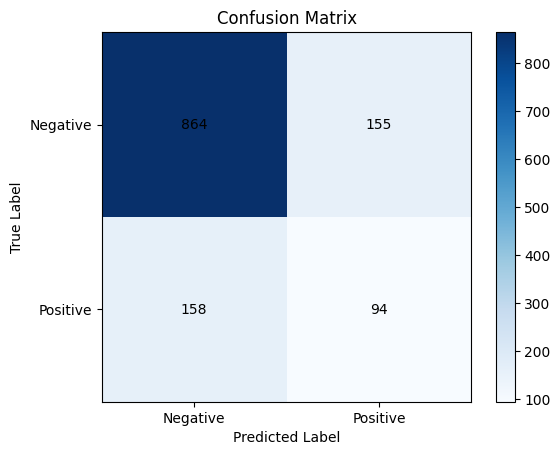

In [83]:
import numpy as np
import matplotlib.pyplot as plt


# Example values (replace with your actual values)
tn, fp, fn, tp = (864, 155, 158, 94)

conf_matrix = np.array([[tn, fp], [fn, tp]])

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')


plt.savefig('../results/cm_span')
